In [1]:
import torch
import numpy as np

import torchvision
from torch.utils.data import DataLoader
from torch.backends import mps
import matplotlib.pyplot as plt

In [2]:
# Define the transformations
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),  # Resize the image to 224x224
    torchvision.transforms.ToTensor() # Convert the image to a pytorch tensor
])

In [3]:
! pip install python_splitter
import python_splitter
python_splitter.split_from_folder("/Users/dragxn/Desktop/projhealth/Oral Cancer", train=0.7, test=0.3)

✅Checking SOURCE directory...
0.7 0 0.3
✅Checking percentage validation...
✅Making required directories...
✅Shuffling data...
✅Getting ready for copying files...

-------------Successfully splitted !!!--------------- 


In [4]:
# setup some path variables
project_path = './'

data_path =  '/Users/dragxn/Desktop/projhealth/Train_Test_Folder/'
# Define train / test dataset
train_dataset = torchvision.datasets.ImageFolder(data_path + 'train/', transform=image_transform)
test_dataset = torchvision.datasets.ImageFolder(data_path + 'test/', transform=image_transform)

# Check the classes labels
class_labels = train_dataset.classes
print(class_labels)
# Check the number of samples in the train and test dataset
print('Number of images in train set:', len(train_dataset))
print('Number of images in test set:', len(test_dataset))

['Normal', 'Squamous Cell Carcinoma']
Number of images in train set: 7000
Number of images in test set: 3002


Image Shape: torch.Size([3, 224, 224])
Label: Normal


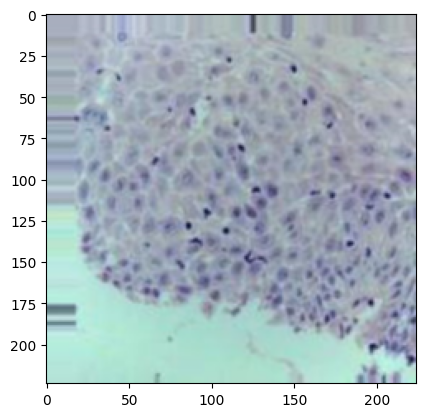

In [5]:
def imshow(img, title=None):
  ''' function to show image '''
  plt.imshow(img.permute(1, 2, 0))
  if title is not None:
    plt.title(title)
  plt.show()
# Show sample image
sample_idx = 240
sample_image, sample_label = train_dataset[sample_idx]
print(f'Image Shape: {sample_image.shape}')
print(f'Label: {class_labels[sample_label]}')

imshow(sample_image)

Shape of image tensors: torch.Size([8, 3, 224, 224])
Shape of label tensors: torch.Size([8])


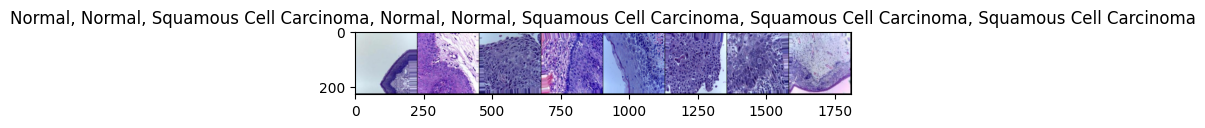

Normal, Normal, Squamous Cell Carcinoma, Normal, Normal, Squamous Cell Carcinoma, Squamous Cell Carcinoma, Squamous Cell Carcinoma
['Normal', 'Normal', 'Squamous Cell Carcinoma', 'Normal', 'Normal', 'Squamous Cell Carcinoma', 'Squamous Cell Carcinoma', 'Squamous Cell Carcinoma']


In [6]:
batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# get a batch of images and labels
images, labels = next(iter(train_loader))
print(f'Shape of image tensors: {images.shape}')
print(f'Shape of label tensors: {labels.shape}')

# Display the batch of images
class_labels_string = ', '.join([class_labels[label] for label in labels]) # Create a string of class labels indexed by labels
imshow(torchvision.utils.make_grid(images), title = class_labels_string)
# plt.title(class_labels_string)

print(class_labels_string)

print([class_labels[label] for label in labels])

In [7]:
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu

class testmodel(nn.Module):

  def __init__(self, num_classes=2):
    super(testmodel, self).__init__()

    # convolutional layer 1 & max pool layer 1
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))

    # convolutional layer 2 & max pool layer 2
    self.layer2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=4),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))

    self.layer3 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=4),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))

    #Fully connected layer
    self.fc = nn.Linear(128*25*25, num_classes)
  # Feed forward the network
  def forward(self, x):
      out = self.layer1(x)
      out = self.layer2(out)
      out = self.layer3(out)
      out = out.reshape(out.size(0), -1)
      out = self.fc(out)
      return out
# Define the model
net = testmodel()
print(net)

testmodel(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=80000, out_features=2, bias=True)
)


In [ ]:
import torch
import numpy as np

import torchvision
from torch.utils.data import DataLoader
from torch.backends import mps
import torch.optim as optim
import matplotlib.pyplot as plt

import time

# Assuming net is your model
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

num_epochs = 50

start_time = time.time()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_index, data in enumerate(train_loader):
        images, labels = data
        optimizer.zero_grad()

        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch: {epoch}, Loss: {epoch_loss}')

end_time = time.time()
execution_time = end_time - start_time
print(f"Training completed in {execution_time} seconds")

torch.save(net.state_dict(), project_path + 'oral_net.pth')

net = testmodel()
net.load_state_dict(torch.load(project_path + 'oral_net.pth'))

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d test images: %d %%' % (total, 100 * correct / total))